In [2]:
import json
from pprint import pprint
import pandas as pd
import random

def load_mongo_collection(filename):
    collection = []
    with open(filename) as fd:
        while True:
            line = fd.readline()
            if line:
                data = json.loads(line)
                collection.append(data)
            else:
                break
    
    return collection

attack_log = load_mongo_collection("./csic_attack_log.json") + load_mongo_collection("./modsec_attack_log.json")
normal_log = load_mongo_collection("./csic_normal_log.json") + load_mongo_collection("./my_normal_log.json")

# collect all available rules
all_rules = set()
for item in attack_log:
    [all_rules.add(x["id"]) for x in item["matched_rules"]]

for item in normal_log:
    [all_rules.add(x["id"]) for x in item["matched_rules"]]

display(len(all_rules), list(all_rules)[:10])

normal_log = random.sample(normal_log, len(attack_log)*3)

display(len(attack_log), len(normal_log))
pprint(attack_log[0])
pprint(normal_log[0])

156

[944130,
 943110,
 942100,
 942101,
 921110,
 942110,
 921120,
 942120,
 921130,
 941100]

23764

71292

{'_id': {'$oid': '5ecbcc60140ff600050519e2'},
 'matched_rules': [{'id': 920273,
                    'matched_value': 'Matched "Operator `ValidateByteRange\' '
                                     'with parameter '
                                     "`38,44-46,48-58,61,65-90,95,97-122' "
                                     "against variable `REQUEST_BODY' (Value: "
                                     '`modo=entrar&login=arro&pwd=CarMinAR%3C%21--%23include+file%3D%22archivo_secreto%22+--%3E&remember=on '
                                     "(10 characters omitted)' )",
                    'msg': 'Invalid character in request (outside of very '
                           'strict set)'},
                   {'id': 941180,
                    'matched_value': 'Matched "Operator `Pm\' with parameter '
                                     '`document.cookie document.write '
                                     '.parentnode .innerhtml window.location '
                                     "

In [3]:
from sklearn.model_selection import train_test_split

def transform_log_item(item):
    global all_rules
    transformed_data = {
        "request_method": item.get("request_method"),
        # "uri": item.get("uri")
    }

    for rule_id in all_rules:
        transformed_data[str(rule_id)] = 0

    for rule_id in map(lambda x: x["id"], item.get("matched_rules")):
        transformed_data[str(rule_id)] = 1

    return transformed_data

cleaned_attack_log = [transform_log_item(x) for x in attack_log]
cleaned_normal_log = [transform_log_item(x) for x in normal_log]

X = pd.DataFrame(cleaned_attack_log + cleaned_normal_log)
# convert request_method using one hot encoding
temp = pd.get_dummies(X["request_method"], prefix="request_method")
X = pd.concat([X, temp], axis=1).drop(["request_method"], axis=1)

Y = pd.Series([1]*len(cleaned_attack_log) + [0]*len(cleaned_normal_log))

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=1)

display("X train")
display(X_train.head(), X_train.shape)

display("Y train")
display(Y_train.head())

display("X test")
display(X_test.head(), X_test.shape)

display("Y test")
display(Y_test.head())

'X train'

,944130,943110,942100,942101,921110,942110,921120,942120,921130,941100,...,920500,951240,944100,944110,944120,request_method_GET,request_method_HEAD,request_method_OPTIONS,request_method_POST,request_method_PUT
41568,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
75137,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2448,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2612,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
63607,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


(63687, 161)

'Y train'

41568    0
75137    0
2448     1
2612     1
63607    0
dtype: int64

'X test'

,944130,943110,942100,942101,921110,942110,921120,942120,921130,941100,...,920500,951240,944100,944110,944120,request_method_GET,request_method_HEAD,request_method_OPTIONS,request_method_POST,request_method_PUT
65431,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
58623,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
63386,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
92254,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
87151,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


(31369, 161)

'Y test'

65431    0
58623    0
63386    0
92254    0
87151    0
dtype: int64

In [4]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(criterion="entropy", max_depth=15)

tree_clf.fit(X_train, Y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=15)

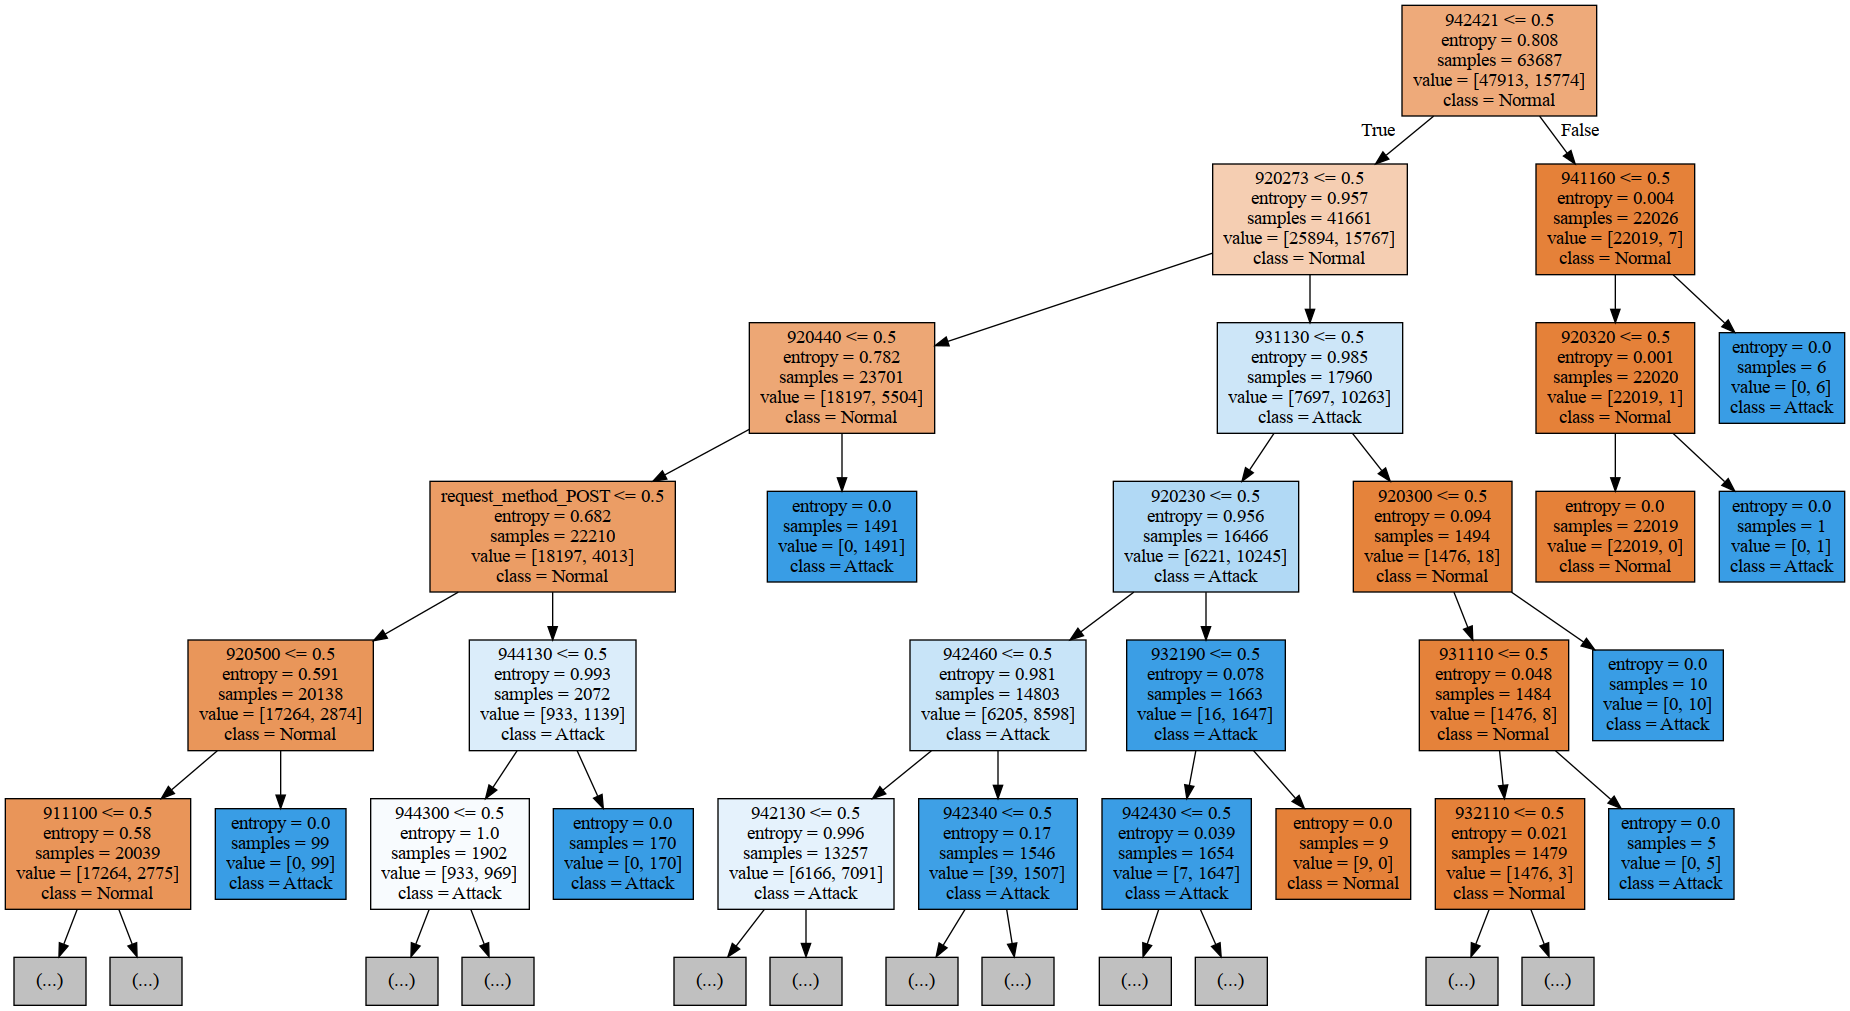

In [5]:
from sklearn.tree import export_graphviz
from subprocess import check_call
from PIL import Image

with open("./decision_tree.dot", "w") as fd:
    export_graphviz(tree_clf, out_file=fd, feature_names=X_train.columns, class_names=('Normal', 'Attack'), max_depth=5, filled=True)

check_call("dot -Tpng decision_tree.dot -o decision_tree.png", shell=True)

with open("./decision_tree_full.dot", "w") as fd:
    export_graphviz(tree_clf, out_file=fd, feature_names=X_train.columns, class_names=('Normal', 'Attack'), filled=True)

check_call("dot -Tpng decision_tree_full.dot -o decision_tree_full.png", shell=True)

img = Image.open("./decision_tree.png")
display(img)

In [6]:
train_score = tree_clf.score(X_train, Y_train)
test_score = tree_clf.score(X_test, Y_test)

display(train_score, test_score)

0.8832885832273463

0.8835474513054289

In [7]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(criterion="entropy", max_depth=20)

forest_clf.fit(X_train, Y_train)
forest_train_score =  forest_clf.score(X_train, Y_train)
forest_test_score = forest_clf.score(X_test, Y_test)

display(forest_train_score, forest_test_score)

0.8762698823935811

0.8759284644075361

In [8]:
import pickle
from sklearn_porter import Porter

# save decision tree and random forest model
with open("decision_tree_model.pickle", "wb") as fd:
    pickle.dump(tree_clf, fd)

with open("random_forest_model.pickle", "wb") as fd:
    pickle.dump(forest_clf, fd)

# test
with open("random_forest_model.pickle", "rb") as fd:
    model = pickle.load(fd)

display(model.score(X_test, Y_test))

# export model to C code for production
with open("./decision_tree.c", "w") as fd:
    porter = Porter(tree_clf, language='C')
    fd.write(porter.export(embed_data=True))

with open("./random_forest.c", "w") as fd:
    porter = Porter(forest_clf, language='C')
    fd.write(porter.export(embed_data=True))

0.8759284644075361

In [9]:
X_train.columns

Index(['944130', '943110', '942100', '942101', '921110', '942110', '921120',
       '942120', '921130', '941100',
       ...
       '920500', '951240', '944100', '944110', '944120', 'request_method_GET',
       'request_method_HEAD', 'request_method_OPTIONS', 'request_method_POST',
       'request_method_PUT'],
      dtype='object', length=161)

In [10]:
# convert features to lua table

lua_features = "features = {\n"

for feature in X_test.columns:
    lua_features += f"\t'{feature}',\n"
lua_features += "}"

print(lua_features)

features = {
	'944130',
	'943110',
	'942100',
	'942101',
	'921110',
	'942110',
	'921120',
	'942120',
	'921130',
	'941100',
	'941101',
	'942130',
	'941110',
	'942140',
	'921150',
	'921151',
	'941120',
	'942150',
	'921160',
	'941130',
	'942160',
	'944210',
	'941140',
	'921180',
	'941150',
	'942180',
	'921190',
	'941160',
	'920170',
	'942190',
	'944240',
	'941170',
	'920180',
	'942200',
	'944250',
	'941180',
	'942210',
	'941190',
	'942220',
	'941200',
	'942230',
	'941210',
	'920220',
	'942240',
	'941220',
	'920230',
	'942250',
	'942251',
	'944300',
	'941230',
	'920240',
	'942260',
	'941240',
	'942270',
	'941250',
	'920260',
	'942280',
	'941260',
	'920270',
	'920271',
	'920272',
	'920273',
	'920274',
	'942290',
	'934100',
	'941270',
	'942300',
	'941280',
	'942310',
	'941290',
	'920300',
	'933100',
	'942320',
	'941300',
	'933110',
	'933111',
	'942330',
	'911100',
	'941310',
	'920320',
	'933120',
	'932100',
	'942340',
	'941320',
	'932105',
	'933130',
	'933131',
	'932106',
	'932110',
	'942350